# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-mhx6UJW0-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 72519.59 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 100075.51 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 120513.27 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 128045.11 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 138720.32 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 146527.85 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 75108.01 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 107783.07 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 127731.76 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 136327.16 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 143263.75 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 148916.69 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.42 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.47 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.18 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.41 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.54 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.11 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.94 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.08 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.17 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.12 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.44 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.46 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.19 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.17 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.76 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.37 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.12 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.13 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.63 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.57 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.48 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.41 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.82 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.03 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.25 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 48.83 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.43 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.93 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.28 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.54 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 36.81 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.19 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.21 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 35.89 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 41.17 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 44.75 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 46.24 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 45.63 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.59 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.81 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.57 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.88 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.80 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.22 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.54 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.81 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 27.00 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.09 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.12 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.75 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.44 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.82 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.79 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.11 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 48.77 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 43.89 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 44.58 examples/s]

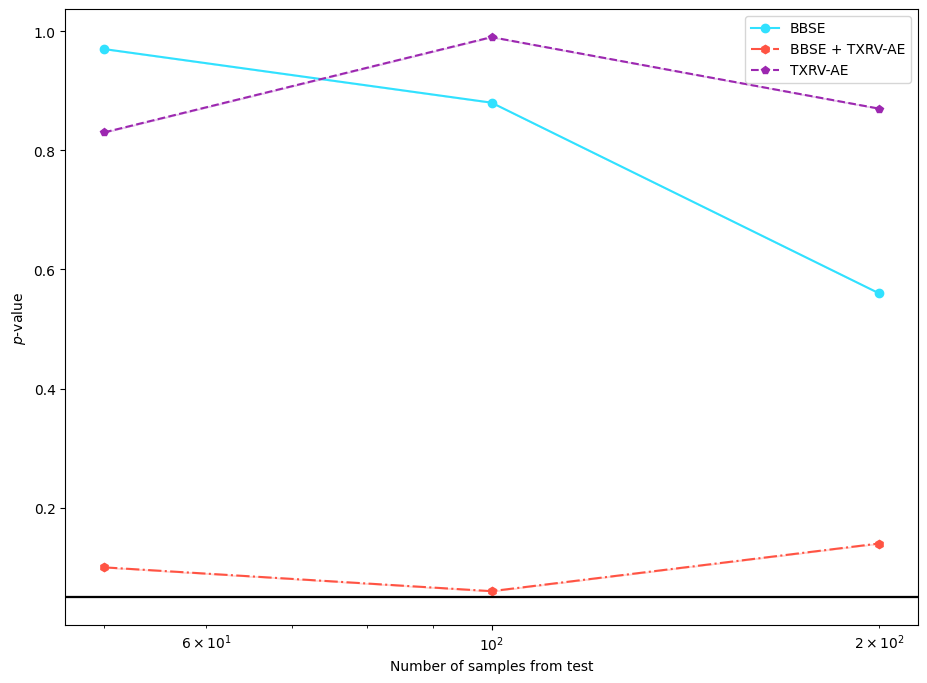

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.19 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.35 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.92 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.41 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.65 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.92 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.99 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.27 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.14 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:02<00:05, 13.37 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 23.88 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 31.44 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:15, 10.85 examples/s]

Map:  32%|███▏      | 64/200 [00:03<00:06, 20.27 examples/s]

Map:  48%|████▊     | 96/200 [00:04<00:03, 27.89 examples/s]

Map:  64%|██████▍   | 128/200 [00:04<00:02, 34.50 examples/s]

Map:  80%|████████  | 160/200 [00:05<00:01, 38.05 examples/s]

Map:  96%|█████████▌| 192/200 [00:06<00:00, 40.28 examples/s]

Map: 100%|██████████| 200/200 [00:06<00:00, 40.18 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.11 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.54 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.02 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.18 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.73 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.61 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.57 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.28 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.15 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:03<00:07,  9.46 examples/s]

Map:  64%|██████▍   | 64/100 [00:06<00:03, 10.47 examples/s]

Map:  96%|█████████▌| 96/100 [00:07<00:00, 13.47 examples/s]

Map: 100%|██████████| 100/100 [00:08<00:00, 13.59 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.99 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.59 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.68 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.06 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 48.95 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.70 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 48.91 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.12 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.26 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.40 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.53 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.57 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.19 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.03 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.62 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.33 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.69 examples/s]

Map:  64%|██████▍   | 64/100 [00:03<00:02, 17.89 examples/s]

Map:  96%|█████████▌| 96/100 [00:04<00:00, 20.02 examples/s]

Map: 100%|██████████| 100/100 [00:05<00:00, 20.23 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:15, 10.79 examples/s]

Map:  32%|███▏      | 64/200 [00:03<00:06, 20.62 examples/s]

Map:  48%|████▊     | 96/200 [00:04<00:03, 29.27 examples/s]

Map:  64%|██████▍   | 128/200 [00:04<00:01, 36.38 examples/s]

Map:  80%|████████  | 160/200 [00:05<00:00, 41.96 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 46.07 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 46.20 examples/s]

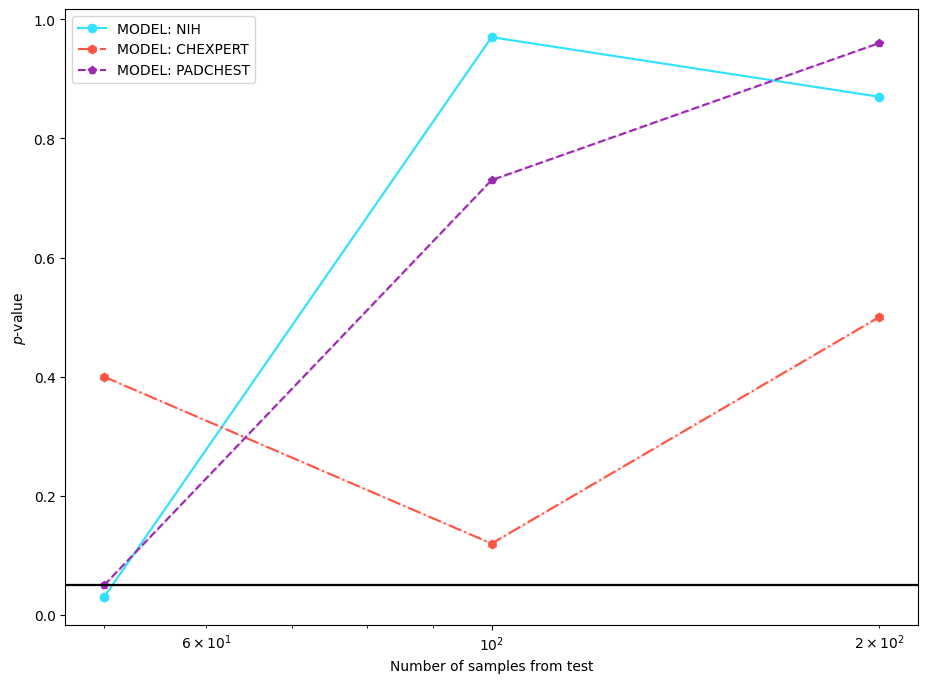

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 50111.12 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 69065.73 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 77992.29 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 85343.63 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 88137.76 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 96246.72 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 47711.49 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 67987.32 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 77765.55 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 83472.84 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 85253.34 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 88441.48 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.60 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.66 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.26 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.60 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.28 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.48 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.44 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:03<00:01, 10.49 examples/s]

Map: 100%|██████████| 50/50 [00:04<00:00, 11.56 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:02<00:04, 14.91 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 26.11 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 32.85 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:14, 11.30 examples/s]

Map:  32%|███▏      | 64/200 [00:03<00:06, 21.72 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 30.32 examples/s]

Map:  64%|██████▍   | 128/200 [00:04<00:01, 36.86 examples/s]

Map:  80%|████████  | 160/200 [00:05<00:00, 42.12 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 45.41 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 45.42 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:02, 45634.19 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 62281.87 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 74959.80 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:01<00:00, 77923.41 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 82855.97 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 87750.66 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:02, 44081.54 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 60980.69 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 70338.31 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:01<00:00, 77805.41 examples/s]

Filter (num_proc=6):  80%|████████  | 89748/112120 [00:01<00:00, 71559.28 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 89562.60 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:15, 11.19 examples/s]

Map:  32%|███▏      | 64/200 [00:03<00:07, 19.22 examples/s]

Map:  48%|████▊     | 96/200 [00:04<00:03, 26.92 examples/s]

Map:  64%|██████▍   | 128/200 [00:04<00:02, 34.22 examples/s]

Map:  80%|████████  | 160/200 [00:05<00:00, 40.42 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 44.13 examples/s]

Map: 100%|██████████| 200/200 [00:06<00:00, 44.71 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:03<00:01,  9.79 examples/s]

Map: 100%|██████████| 50/50 [00:03<00:00, 15.49 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:02<00:04, 13.92 examples/s]

Map:  64%|██████▍   | 64/100 [00:04<00:02, 15.85 examples/s]

Map:  96%|█████████▌| 96/100 [00:06<00:00, 13.73 examples/s]

Map: 100%|██████████| 100/100 [00:07<00:00, 12.47 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:12, 13.61 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 24.42 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 33.28 examples/s]

Map:  64%|██████▍   | 128/200 [00:04<00:01, 37.39 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 42.06 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 42.70 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 42.16 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 49086.49 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 67148.61 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 76895.27 examples/s]

Filter (num_proc=6):  62%|██████▏   | 69061/112120 [00:01<00:00, 67645.52 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 85894.43 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 89406.66 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 50753.52 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 71183.47 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 80655.87 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 89033.50 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 90853.85 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 92572.67 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.10 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.98 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.81 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.83 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.52 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.46 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.19 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.61 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.97 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.54 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.97 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.67 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.04 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.07 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 36.38 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 39.66 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 45.07 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 45.07 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 45.44 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51312.89 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 69309.64 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 76164.48 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 86474.71 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 87773.65 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 91607.13 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:02, 46078.46 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 66149.01 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 80217.81 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 86468.24 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 88304.27 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 91128.26 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.25 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.24 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.23 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.39 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.67 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.24 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.82 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.05 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.80 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.63 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.15 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.21 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.86 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.64 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.27 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.28 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 46.98 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.98 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.51 examples/s]

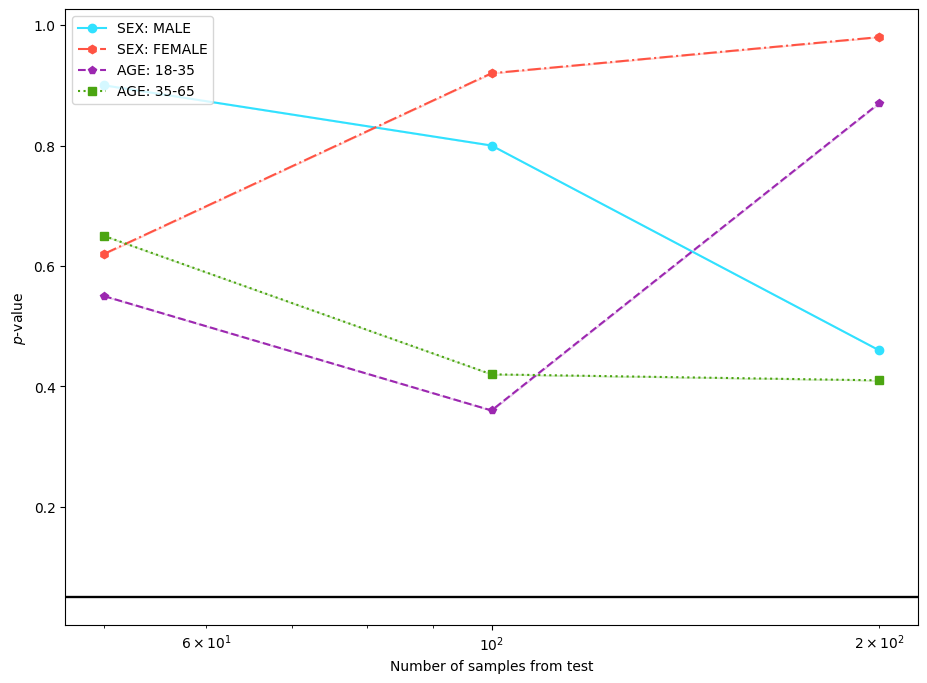

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.57 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.38 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.34 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.85 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.82 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 48.03 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 48.40 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.82 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.54 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.68 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.35 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.82 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 21.80 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.63 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.48 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.32 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.74 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.72 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.06 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.97 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.85 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.85 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.78 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.75 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.47 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.99 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.05 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.98 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.76 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.32 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.07 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.94 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 27.02 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.69 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.08 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.41 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.74 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.35 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.70 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.37 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.37 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.98 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.13 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.41 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.98 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.16 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.58 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.33 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.71 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.73 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.79 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.35 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.37 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.30 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.17 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.69 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 27.02 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.03 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.42 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.00 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.36 examples/s]

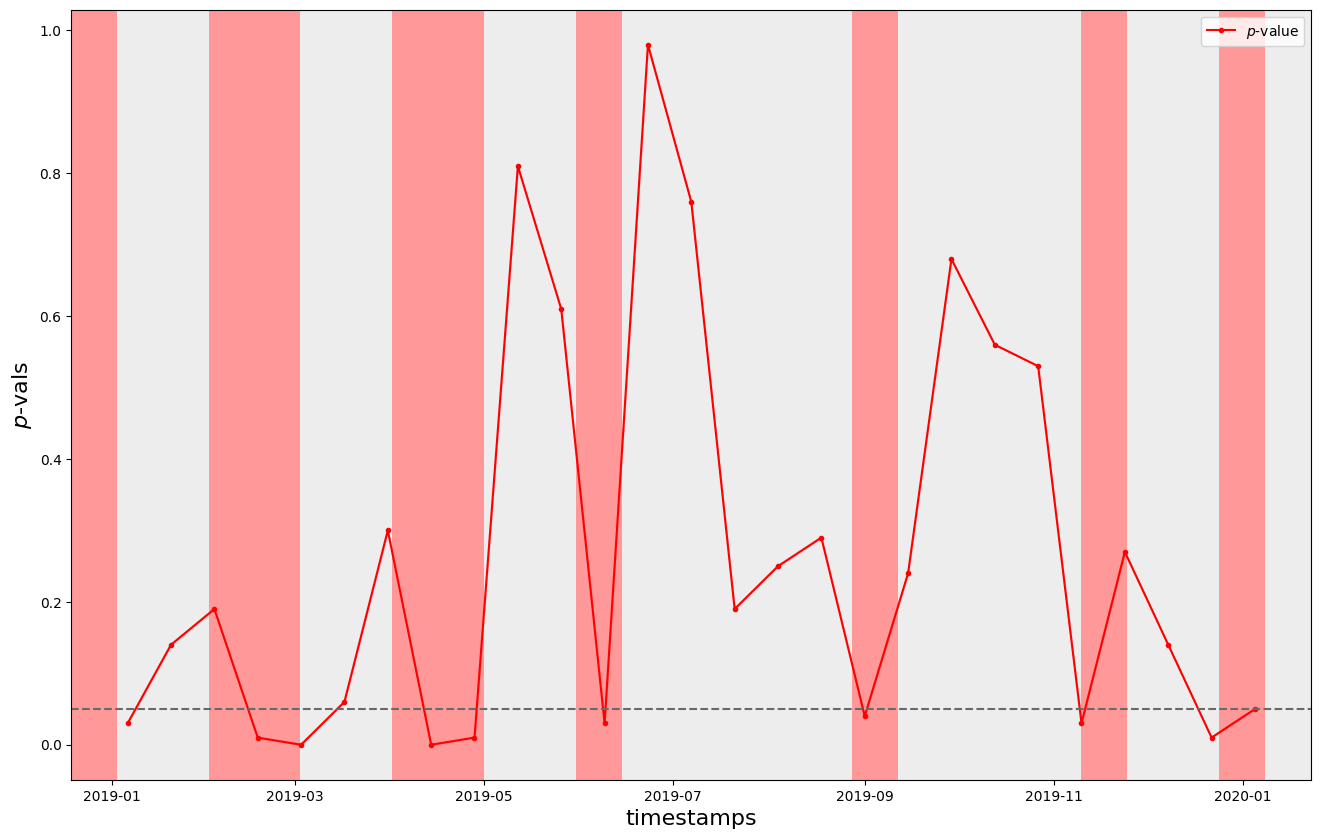

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)